In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
# Imports here
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim import lr_scheduler
from PIL import Image
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter
import json
from collections import OrderedDict


In [3]:
#checking for gpu

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls
!pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data
/content


In [0]:
data_dir = 'gdrive/My Drive/ProjectWorks/flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [0]:
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(90),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

val_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
val_data = datasets.ImageFolder(valid_dir, transform = val_transform)
test_data = datasets.ImageFolder(test_dir, transform = test_transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(val_data, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16)

In [0]:
with open('gdrive/My Drive/ProjectWorks/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
model = models.resnet152(pretrained=True)


In [0]:
for param in model.parameters():
    param.requires_grad = False

In [0]:
classifier = nn.Sequential(OrderedDict([
                          #('adaptive_pool',nn.AdaptiveAvgPool2d((1,1))),
                          #('adaptive_maxpool',nn.AdaptiveMaxPool2d((1,1))),
                          #('flatten',nn.Flatten()),
                          ('batch_norm',nn.BatchNorm1d(2048,eps=1e-05, momentum=0.1, affine=True)),
                          ('Dropout',nn.Dropout(0)),
                          ('fc1', nn.Linear(2048, 520)),
                          ('activation', nn.ReLU()),
                          ('fc2', nn.Linear(520, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
model.fc = classifier

In [0]:
if train_on_gpu:
  model.cuda()

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0003)
lrsheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [13]:
epochs = 25
print_every = 40
steps = 0
valid_loss_min = np.Inf
total = 0
correct = 0

# change to cuda
model.to('cuda')
validation_loss = 0
for e in range(epochs):
    training_loss = 0
    lrsheduler.step(validation_loss)
    model.train()
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()*inputs.size(0)
        
        
    model.eval()
    for ii, (inputs, labels) in enumerate(validloader):

        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

        validation_loss += loss.item()*inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    training_loss = training_loss/len(trainloader.dataset)
    validation_loss = validation_loss/len(validloader.dataset)
    _correct = (correct*100)/total
    
    
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.6f}'.format(
        e, training_loss, validation_loss, _correct))
    
    if validation_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        
    #to save the check-points
        model.class_to_idx = train_data.class_to_idx
        checkpoint = {'architecture': 'densenet161',
                'classifier': model.fc,
                'class_to_idx': model.class_to_idx,
                'state_dict': model.state_dict()}
        
        torch.save(checkpoint, 'model_challenge_2.pt')
        valid_loss_min = validation_loss

Epoch: 0 	Training Loss: 2.564543 	Validation Loss: 1.053379 	Accuracy: 75.183374
Validation loss decreased (inf --> 1.053379).  Saving model ...
Epoch: 1 	Training Loss: 1.028828 	Validation Loss: 0.593166 	Accuracy: 80.195599
Validation loss decreased (1.053379 --> 0.593166).  Saving model ...
Epoch: 2 	Training Loss: 0.779445 	Validation Loss: 0.525902 	Accuracy: 81.703341
Validation loss decreased (0.593166 --> 0.525902).  Saving model ...
Epoch: 3 	Training Loss: 0.670153 	Validation Loss: 0.507932 	Accuracy: 82.701711
Validation loss decreased (0.525902 --> 0.507932).  Saving model ...
Epoch: 4 	Training Loss: 0.626908 	Validation Loss: 0.418709 	Accuracy: 83.789731
Validation loss decreased (0.507932 --> 0.418709).  Saving model ...
Epoch: 5 	Training Loss: 0.606746 	Validation Loss: 0.408379 	Accuracy: 84.698452
Validation loss decreased (0.418709 --> 0.408379).  Saving model ...
Epoch: 6 	Training Loss: 0.559654 	Validation Loss: 0.367684 	Accuracy: 85.312609
Validation loss d

In [0]:
for param in model.parameters():
        param.requires_grad = True

optimizer = optim.Adagrad(model.parameters(), lr=0.0003)
lrsheduler1 = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
lrsheduler2 = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.1, patience = 3)

In [15]:
epochs = 15
print_every = 40
steps = 0
valid_loss_min = validation_loss
validation_loss = 0
total = 0
correct = 0

# change to cuda
model.to('cuda')
lrsheduler = lrsheduler1
for e in range(epochs):
    training_loss = 0
    #validation_loss = 0
    lrsheduler.step(validation_loss)
    model.train()
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()*inputs.size(0)
            
    model.eval()
    for ii, (inputs, labels) in enumerate(validloader):

        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

        validation_loss += loss.item()*inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    training_loss = training_loss/len(trainloader.dataset)
    validation_loss = validation_loss/len(validloader.dataset)
    _correct = (correct*100)/total
    
    if epochs > 7 and _correct < 98:
      lrsheduler = lrsheduler2
      
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.6f}'.format(
        e, training_loss, validation_loss, _correct))
    
    if validation_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        
    #to save the check-points
        model.class_to_idx = train_data.class_to_idx
        checkpoint = {'architecture': 'densenet161',
                'classifier': model.fc,
                'class_to_idx': model.class_to_idx,
                'state_dict': model.state_dict()}
        
        torch.save(checkpoint, 'model_challenge_2.pt')
        valid_loss_min = validation_loss

Epoch: 0 	Training Loss: 0.376404 	Validation Loss: 0.220740 	Accuracy: 94.987775
Validation loss decreased (0.308561 --> 0.220740).  Saving model ...
Epoch: 1 	Training Loss: 0.216206 	Validation Loss: 0.185674 	Accuracy: 95.171149
Validation loss decreased (0.220740 --> 0.185674).  Saving model ...
Epoch: 2 	Training Loss: 0.200693 	Validation Loss: 0.165252 	Accuracy: 95.680522
Validation loss decreased (0.185674 --> 0.165252).  Saving model ...
Epoch: 3 	Training Loss: 0.172735 	Validation Loss: 0.155353 	Accuracy: 95.874083
Validation loss decreased (0.165252 --> 0.155353).  Saving model ...
Epoch: 4 	Training Loss: 0.159172 	Validation Loss: 0.149778 	Accuracy: 96.039120
Validation loss decreased (0.155353 --> 0.149778).  Saving model ...
Epoch: 5 	Training Loss: 0.148099 	Validation Loss: 0.150388 	Accuracy: 96.128769
Epoch: 6 	Training Loss: 0.145377 	Validation Loss: 0.148250 	Accuracy: 96.192805
Validation loss decreased (0.149778 --> 0.148250).  Saving model ...
Epoch: 7 	Tr

In [16]:
# TODO: Do validation on the test set
def check_accuracy_on_test(testloader):    
    correct = 0
    total = 0
    model.to('cuda:0')
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
    
check_accuracy_on_test(testloader)

Accuracy of the network on the test images: 97 %


In [ ]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint():
    """
    Loads deep learning model checkpoint.
    """
    
    # Load the saved file
    checkpoint = torch.load("model_challenge_2.pt")
    
    # Freeze parameters so we don't backprop through them
    for param in model.parameters(): param.requires_grad = False
    
    # Load stuff from checkpoint
    model.class_to_idx = checkpoint['class_to_idx']
    model.fc = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])

    
    return model

load_checkpoint()

#downloading the checkpoints from collaboratory, for googlecolab only
from google.colab import files
files.download("model_challenge_2.pt")

In [19]:
def process_image(image):
    img_pil = Image.open(image)
   
    image_process = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = image_process(img_pil)
    
    return img_tensor
    
    
    # TODO: Process a PIL image for use in a PyTorch model

img = (data_dir + '/test' + '/53/' + 'image_03672.jpg')
img = process_image(img)
print(img.shape)



torch.Size([3, 224, 224])


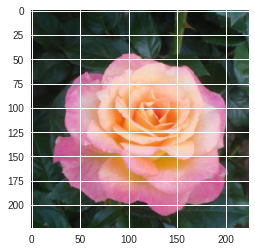

In [21]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

imshow(process_image(data_dir + '/test' + '/74/' + 'image_01254.jpg'))

In [0]:
model.class_to_idx =train_data.class_to_idx

ctx = model.class_to_idx


def predict(image_path, model, topk=5):   
    model.to('cuda:0')
    img_torch = process_image(image_path)
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    
    with torch.no_grad():
        output = model.forward(img_torch.cuda())
        
    probability = F.softmax(output.data,dim=1)
    
    return probability.topk(topk)
    
    # TODO: Implement the code to predict the class from an image file

In [24]:
img = (data_dir + '/test' + '/74/' + 'image_01254.jpg')
val1, val2 = predict(img, model)
print(val1)
print(val2)

tensor([[0.9959, 0.0034, 0.0004, 0.0003, 0.0000]], device='cuda:0')
tensor([[74, 98, 99, 81, 78]], device='cuda:0')


In [0]:
def check_sanity(path):
    plt.rcParams["figure.figsize"] = (10,5)
    plt.subplot(211)
    
    index = int(path.split('/')[1])
    paths = test_dir + path

    probabilities = predict(paths, model)
    image = process_image(paths)
    probabilities = probabilities
    

    axs = imshow(image, ax = plt)
    axs.axis('off')
    axs.title(cat_to_name[str(index)])
    axs.show()
    
    
    a = np.array(probabilities[0][0])
    b = [cat_to_name[str(index)] for index in np.array(probabilities[1][0])]
    
    
    N=float(len(b))
    fig,ax = plt.subplots(figsize=(8,3))
    width = 0.8
    tickLocations = np.arange(N)
    ax.bar(tickLocations, a, width, linewidth=4.0, align = 'center')
    ax.set_xticks(ticks = tickLocations)
    ax.set_xticklabels(b)
    ax.set_xlim(min(tickLocations)-0.6,max(tickLocations)+0.6)
    ax.set_yticks([0.2,0.4,0.6,0.8,1,1.2])
    ax.set_ylim((0,1))
    ax.yaxis.grid(True)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.show()

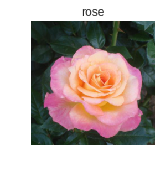

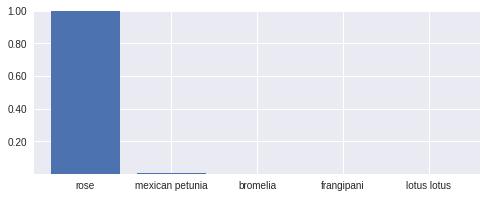

In [47]:
check_sanity('/74/image_01254.jpg')

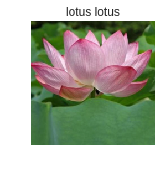

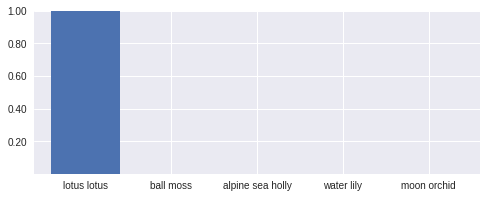

In [49]:
flowers_ = ['/74/image_01254.jpg','/73/image_00324.jpg','/78/image_01874.jpg','/83/image_01737.jpg']
check_sanity('/78/image_01874.jpg')

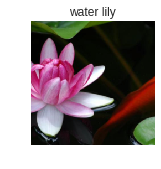

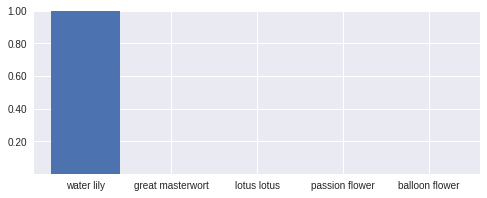

In [48]:
check_sanity('/73/image_00324.jpg')